<a href="https://colab.research.google.com/github/aditya-singam/shapclustering/blob/main/Pioneer_Research_Code_Aditya_Singampalli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Download the MovieLens 100K Dataset
!pip install shap
!pip install umap-learn
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 284.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
--2024-07-02 05:29:10--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  27.8MB/s    in 0.2s    

2024-07-02 05:29:10 (27.8 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating:

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


# Load MovieLens dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None,
                     names=['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] +
                            ['genre_' + str(i) for i in range(19)])

# Merge ratings with movies to get genre information
data = pd.merge(ratings, movies, on='movieId')

# Step 1: Define a function to get the favorite genre for each user
def get_favorite_genre(user_data):
    high_rated = user_data[user_data['rating'] >= 4]
    # Select genre columns and ensure they are numeric
    genres = high_rated.iloc[:, 5:].apply(pd.to_numeric, errors='coerce').fillna(0)
    # Sum the genre columns
    genres_sum = genres.sum()
    # Ensure genres_sum is numeric
    genres_sum = pd.to_numeric(genres_sum, errors='coerce')
    # Find the genre with the highest sum
    return genres_sum.idxmax()

# Apply the function to get favorite genres
user_genres = data.groupby('userId').apply(get_favorite_genre).reset_index()
user_genres.columns = ['userId', 'favorite_genre']
#print(user_genres)

# Merge favorite genres back with user demographic data
users = pd.read_csv('ml-100k/u.user', sep='|', names=['userId', 'age', 'gender', 'occupation', 'zip_code'])
data = pd.merge(users, user_genres, on='userId')

# Convert categorical columns to numeric
data['gender'] = data['gender'].map({'M': 1, 'F': 2})
data = pd.concat([data, pd.get_dummies(data['occupation'], prefix='occ')], axis=1)

data['zip_code'] = pd.to_numeric(data['zip_code'], errors='coerce').fillna(-1).astype(int)
print(data.head())

X = data.drop(columns=['userId', 'favorite_genre', 'occupation'])
y = data['favorite_genre']

le = LabelEncoder()
y = le.fit_transform(y)


model = xgb.XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X)
accuracy = accuracy_score(y,y_pred)
print(f"Accuracy: {accuracy:.2f}")

   userId  age  gender  occupation  zip_code favorite_genre  \
0       1   24       1  technician     85711        genre_8   
1       2   53       2       other     94043        genre_8   
2       3   23       1      writer     32067        genre_8   
3       4   24       1  technician     43537       genre_16   
4       5   33       2       other     15213        genre_5   

   occ_administrator  occ_artist  occ_doctor  occ_educator  ...  \
0              False       False       False         False  ...   
1              False       False       False         False  ...   
2              False       False       False         False  ...   
3              False       False       False         False  ...   
4              False       False       False         False  ...   

   occ_marketing  occ_none  occ_other  occ_programmer  occ_retired  \
0          False     False      False           False        False   
1          False     False       True           False        False   
2       

*************


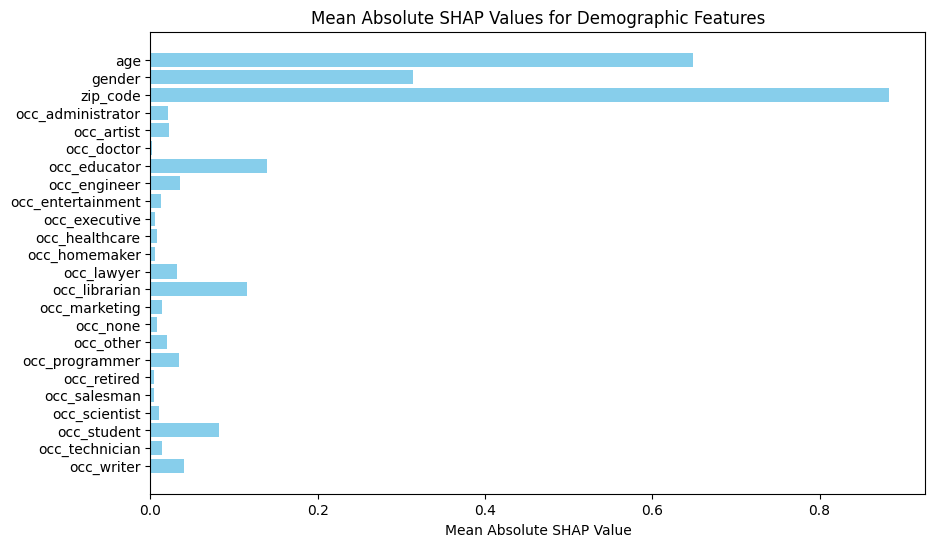

              feature  mean_abs_shap
0                 age       0.649225
1              gender       0.313307
2            zip_code       0.882478
3   occ_administrator       0.020685
4          occ_artist       0.022551
5          occ_doctor       0.002041
6        occ_educator       0.139668
7        occ_engineer       0.034723
8   occ_entertainment       0.013181
9       occ_executive       0.005348
10     occ_healthcare       0.007735
11      occ_homemaker       0.004868
12         occ_lawyer       0.032199
13      occ_librarian       0.115589
14      occ_marketing       0.013290
15           occ_none       0.008285
16          occ_other       0.019712
17     occ_programmer       0.033629
18        occ_retired       0.004637
19       occ_salesman       0.004295
20      occ_scientist       0.009678
21        occ_student       0.081498
22     occ_technician       0.013656
23         occ_writer       0.040620


In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# Step 4: Calculate SHAP Values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X, check_additivity=False)

# Step 5: Calculate the mean absolute SHAP value for each demographic feature
demographic_features = ['age', 'gender', "zip_code"] + [col for col in X.columns if col.startswith('occ_')]
shap_values_demographic = np.abs(shap_values).mean(axis=0)  # Calculate mean absolute SHAP values

print("*************")


shap_df_demographic = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_values_demographic.mean(axis=1) # Take mean across classes to get single value per feature
})

# Filter for just the demographic features
shap_df_demographic = shap_df_demographic[shap_df_demographic['feature'].isin(demographic_features)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(shap_df_demographic['feature'], shap_df_demographic['mean_abs_shap'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values for Demographic Features')
plt.gca().invert_yaxis()
plt.show()

scaler = MinMaxScaler()
normalized_shap_values = scaler.fit_transform(shap_df_demographic['mean_abs_shap'].values.reshape(-1, 1)).flatten()

# Create weighted features
weighted_features = X[demographic_features] * normalized_shap_values

#shap_df_demographic = pd.DataFrame({'feature': X_train.columns, 'mean_abs_shap': shap_values_demographic[0]})
print(shap_df_demographic)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[8 8 8 4 7 8 8 0 8 8 8 8 8 8 8 8 8 8 7 0 1 0 8 8 7 8 8 4 8 7 8 8 4 8 4 8 0
 7 8 8 7 8 7 8 7 8 8 8 7 8 0 8 0 0 0 0 7 8 8 8 8 8 8 8 8 8 0 8 8 0 8 8 8 8
 7 8 8 7 8 8 8 8 7 8 8 8 7 8 8 8 8 8 7 8 8 8 3 7 8 8 0 3 0 8 8 8 8 8 0 8 8
 8 8 8 8 8 0 8 8 8 8 8 8 4 7 8 0 8 8 0 8 8 8 0 8 8 0 8 8 8 4 7 4 8 8 8 8 7
 8 8 8 2 8 8 8 8 8 0 7 8 8 0 8 4 8 0 8 7 0 4 8 7 8 8 8 8 8 8 8 8 8 8 0 8 8
 4 8 8 8 8 8 8 8 8 8 7 0 8 8 0 8 7 8 8 8 8 8 7 7 7 8 8 8 8 8 8 0 4 8 8 8 8
 7 8 8 8 8 8 8 8 0 8 8 8 8 8 8 0 8 8 8 8 8 8 0 7 8 0 8 8 8 8 8 0 1 0 8 8 8
 0 4 8 8 7 4 8 0 8 8 8 8 8 8 8 0 8 8 8 7 8 4 8 7 8 8 7 8 8 0 0 8 8 8 0 8 8
 8 8 8 7 0 0 7 2 8 8 7 8 0 5 8 8 8 8 8 8 4 8 8 0 8 8 8 8 8 8 8 8 8 7 8 0 7
 8 4 7 0 8 8 7 8 8 8 8 8 0 8 8 8 8 8 0 8 8 4 8 0 8 0 8 8 4 7 8 8 1 1 0 8 8
 8 4 8 8 4 8 8 8 8 8 8 8 8 4 8 0 8 4 8 8 8 8 7 0 8 4 8 8 8 0 8 8 0 8 8 8 7
 8 8 8 0 8 8 8 4 8 8 4 2 8 4 8 8 8 0 8 8 8 8 8 4 8 8 7 7 8 8 0 8 8 0 0 8 8
 8 8 8 8 8 8 4 8 8 8 8 8 8 8 0 8 8 8 8 4 8 0 8 8 8 8 6 0 8 8 7 7 2 7 8 8 7
 0 0 0 7 8 8 8 4 8 8 8 0 

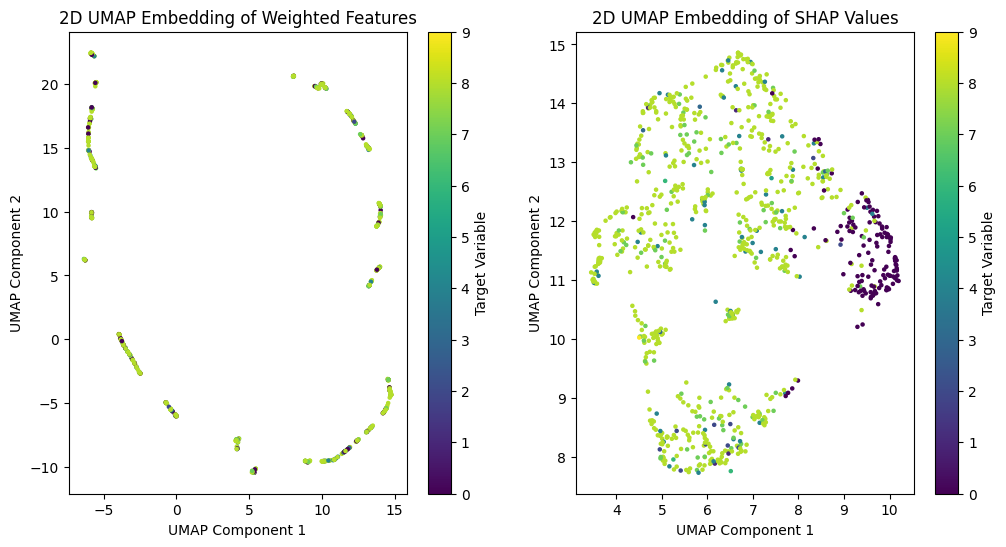

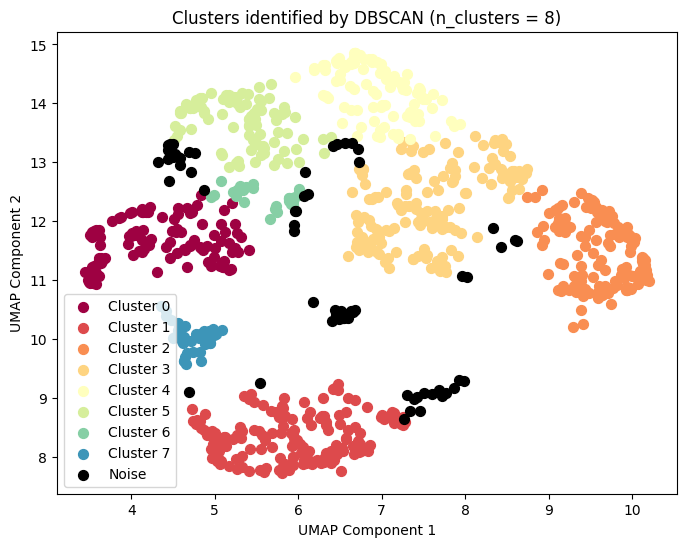

In [8]:
# Perform clustering
# n_clusters = 5
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# clusters = kmeans.fit_predict(weighted_features)

# dbscan = DBSCAN(eps=1.5, min_samples=20)
# clusters = dbscan.fit_predict(weighted_features)

# Visualize clusters using UMAP and DBSCAN
X_2d = UMAP(n_components=2, n_neighbors=200, min_dist=0, random_state = 43).fit_transform(weighted_features)
s_2d = UMAP(n_components=2, n_neighbors=200, min_dist=0, random_state = 43).fit_transform(shap_values[:, :, 0])

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
y_numeric = le.fit_transform(y)
print(y)



# Plotting the 2D embedding of raw variable values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title('2D UMAP Embedding of Weighted Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Target Variable')

# Plotting the 2D embedding of SHAP values
plt.subplot(1, 2, 2)
plt.scatter(s_2d[:, 0], s_2d[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title('2D UMAP Embedding of SHAP Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Target Variable')

x_labels = DBSCAN(eps=0.58, min_samples=40).fit(s_2d).labels_
print("x_labels: ")
print(x_labels)
plt.figure(figsize=(8, 6))
unique_labels2 = set(x_labels)
print("unique_labels2: ")
print(unique_labels2)
n_clusters_2 = len(unique_labels2) - (1 if -1 in unique_labels2 else 0)
colors2 = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels2)))
#print(unique_labels)
#print(colors)
for k, col in zip(unique_labels2, colors2):
    #print(k)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (x_labels == k)
    xy = s_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title(f'Clusters identified by DBSCAN (n_clusters = {n_clusters_2})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
clusters = x_labels
data['cluster'] = clusters
# Prepare user-item matrix for each cluster
def create_user_item_matrix(ratings, cluster_users):
    user_item_matrix = ratings[ratings['userId'].isin(cluster_users)].pivot(index='userId', columns='movieId', values='rating')
    return user_item_matrix

# Split ratings into clusters
cluster_ratings = {}
for cluster in set(clusters):
    if cluster == -1:  # Skip noise points
        continue
    cluster_users = data[data['cluster'] == cluster]['userId']
    cluster_ratings[cluster] = create_user_item_matrix(ratings, cluster_users)

In [10]:
# Calculating Cosine similarity
cluster_similarities = {}
for cluster, user_item_matrix in cluster_ratings.items():
    similarity_matrix = cosine_similarity(user_item_matrix.fillna(0))  # Fill NA with 0 for similarity calculation
    cluster_similarities[cluster] = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

In [11]:
def predict_rating(userId, movieId, cluster):
    user_item_matrix = cluster_ratings.get(cluster, None)
    similarity_matrix = cluster_similarities.get(cluster, None)

    if user_item_matrix is None or similarity_matrix is None:
        return None

    # Check if the user and movie are in the cluster
    if userId not in user_item_matrix.index or movieId not in user_item_matrix.columns:
        return None

    # Get the similarity scores for the user
    sim_scores = similarity_matrix[userId]

    # Get the ratings for the movie
    movie_ratings = user_item_matrix[movieId]

    # Calculate the weighted average rating
    weighted_sum = np.dot(sim_scores, movie_ratings.fillna(0))
    sum_of_weights = np.sum(sim_scores[movie_ratings.notna()])

    if sum_of_weights == 0:
        return None

    predicted_rating = weighted_sum / sum_of_weights
    return predicted_rating

cluster = data[data['userId'] == 1]['cluster'].values[0]
predicted_rating = predict_rating(1, 202, cluster)
print(f"Predicted Rating for User 1 on Movie 1: {predicted_rating:.2f}")

Predicted Rating for User 1 on Movie 1: 3.65


In [12]:
def predict_all_unseen_ratings(userId, cluster):
    # Get the user's rated movies
    user_rated_movies = ratings[ratings['userId'] == userId]['movieId'].tolist()

    # Get all movies
    all_movies = ratings['movieId'].unique()

    # Predict ratings for unseen movies
    unseen_movie_ratings = []
    for movieId in all_movies:
        if movieId not in user_rated_movies:
            predicted_rating = predict_rating(userId, movieId, cluster)
            if predicted_rating is not None:
                unseen_movie_ratings.append((movieId, predicted_rating))

    return unseen_movie_ratings

In [13]:
def rank_movies(predicted_ratings):
    return sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

def recommend_top_movies(userId, cluster, top_n=5):
    predicted_ratings = predict_all_unseen_ratings(userId, cluster)
    ranked_movies = rank_movies(predicted_ratings)
    top_movies = ranked_movies[:top_n]

    # Get movie titles
    top_movie_titles = [movies[movies['movieId'] == movie[0]]['title'].values[0] for movie in top_movies]

    return top_movie_titles

user_id = 1
user_cluster = data[data['userId'] == user_id]['cluster'].values[0]
recommended_movies = recommend_top_movies(user_id, user_cluster)
print(f"Top 5 recommended movies for User {user_id}:")
for i, movie in enumerate(recommended_movies, 1):
    print(f"{i}. {movie}")

Top 5 recommended movies for User 1:
1. Bitter Moon (1992)
2. Bitter Sugar (Azucar Amargo) (1996)
3. Thieves (Voleurs, Les) (1996)
4. Deceiver (1997)
5. Incognito (1997)


In [14]:
from sklearn.model_selection import train_test_split

def train_test_split_ratings(ratings, test_size=0.2):
    train_data = []
    test_data = []

    for user, group in ratings.groupby('userId'):
        n = len(group)
        if n == 1:
            train_data.append(group)
        else:
            train_group, test_group = train_test_split(group, test_size=test_size, random_state=42)
            train_data.append(train_group)
            test_data.append(test_group)

    train_data = pd.concat(train_data)
    test_data = pd.concat(test_data)

       # Add cluster information to train and test data if it exists in original ratings
    if 'cluster' in ratings.columns:
        train_data = train_data.merge(ratings[['userId', 'cluster']], on='userId', how='left')
        test_data = test_data.merge(ratings[['userId', 'cluster']], on='userId', how='left')
    else: # Handle the case where 'cluster' is not in original ratings
        # Assuming 'data' DataFrame contains cluster information
        train_data = train_data.merge(data[['userId', 'cluster']], on='userId', how='left')
        test_data = test_data.merge(data[['userId', 'cluster']], on='userId', how='left')

    return train_data, test_data
train_ratings, test_ratings = train_test_split_ratings(ratings)

In [15]:
def predict_ratings_for_test_set(test_ratings, clusters, train_ratings):
    predictions = []

    for _, row in test_ratings.iterrows():
        userId = row['userId']
        movieId = row['movieId']
        true_rating = row['rating']

        # Check if user exists in train_ratings before accessing cluster
        user_in_train = train_ratings[train_ratings['userId'] == userId]
        if not user_in_train.empty:
            # Get the cluster for the user directly from the train_ratings DataFrame
            user_cluster = train_ratings[train_ratings['userId'] == userId]['cluster'].values[0]
            predicted_rating = predict_rating(userId, movieId, user_cluster)

            if predicted_rating is not None:
                predictions.append((true_rating, predicted_rating))

    return predictions

# Pass train_ratings to the function
predictions = predict_ratings_for_test_set(test_ratings, clusters, train_ratings)

In [16]:
from sklearn.metrics import mean_absolute_error

def calculate_mae(predictions):
    true_ratings = [pred[0] for pred in predictions]
    predicted_ratings = [pred[1] for pred in predictions]

    mae = mean_absolute_error(true_ratings, predicted_ratings)

    return mae

mae = calculate_mae(predictions)
print(f"MAE: {mae:.4f}")

MAE: 0.6375
